In [3]:
# First import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gmaps                                # Used for plotting data on google maps using an API
from matplotlib import cm                   # To get certain color maps for plotting
from matplotlib.colors import to_hex
import ipywidgets as widgets                # Display widgets to help visualization
import json
from statsmodels.stats.weightstats import ttest_ind as sm_ttest
from scipy.stats import ttest_ind as sp_ttest
#from map_utils import single_map, double_choro_map, get_colors_from_attr
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')
pd.set_option('display.width', 500)
pd.set_option('max_columns', 60)

In [2]:
# Load google static map API key. You need a google API key to use their maps
api_key=open('data/api_key.txt')
gmaps.configure(api_key=api_key.read())
api_key.close()

In [3]:
with open('data/crime/community_areas.geojson') as file:
    community_areas=json.load(file)

<a href='https://www.dropbox.com/s/z43pgiwbsw93gnt/all_crimes_clean.csv?dl=0'>Data link</a> for the following analysis.

In [2]:
# Read all the crimes data containing the community area column
all_crimes=pd.read_csv('data/crime/all_crimes_clean.csv', index_col=0, parse_dates=True)

In [3]:
all_crimes.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6478356 entries, 2001-01-01 00:00:00 to 2017-11-12 23:45:00
Data columns (total 22 columns):
ID                      6478356 non-null int64
Case Number             6478352 non-null object
Date.1                  6478356 non-null object
Block                   6478356 non-null object
IUCR                    6478356 non-null object
Primary Type            6478356 non-null object
Description             6478356 non-null object
Location Description    6475409 non-null object
Arrest                  6478356 non-null bool
Domestic                6478356 non-null bool
Beat                    6478356 non-null int64
District                6478307 non-null float64
Ward                    5863502 non-null float64
Community Area          6478356 non-null int64
FBI Code                6478356 non-null object
X Coordinate            6391699 non-null float64
Y Coordinate            6391699 non-null float64
Year                    6478356 non-null 

In [6]:
# Get the center points for each community serving as info box
community_centers=pd.read_csv('data/crime/community_centers.csv')

In [7]:
# Get the names of the community from another file
income=pd.read_csv('data/crime/income_infer.csv')

In [8]:
community_centers['Community Name']=income['Community Name']

In [9]:
color_map=cm.get_cmap('Reds')

<h3>Fourth question: how are the crimes spread out during a 24 h period of the day? Are some hours more dangerous than others?

In [10]:
crime_types=['THEFT', 'BATTERY', 'NARCOTICS', 'BURGLARY', 'ROBBERY', 'WEAPONS VIOLATION', 'SEX OFFENSE', 'HOMICIDE']

In [14]:
# Break down the crime by hour
hours=['12 am']+[str(x)+ ' am' for x in range(1, 12)]+['12 pm']+ [str(y) +' pm' for y in range(1, 12)]
hourly_dfs=[]
for crime in crime_types:
    counts=[]
    for i in range(24):
        hourly=all_crimes[all_crimes.index.hour==i]
        hourly_crime=hourly[hourly['Primary Type']==crime]
        counts.append(len(hourly_crime))
    hourly_dfs.append(pd.DataFrame({'Hours': hours, 'Number of incidents': counts}))
hourly_dfs[0]

,Hours,Number of incidents
0,12 am,78720
1,1 am,30745
2,2 am,24573
3,3 am,19605
4,4 am,14728
5,5 am,14414
6,6 am,20741
7,7 am,33595
8,8 am,52064
9,9 am,71992


In [15]:
# Let's plot all crime rates by hours
# Calculate crime percentage during 24h period
for df in hourly_dfs:
    df['Crime rate']=df['Number of incidents']/df['Number of incidents'].sum()

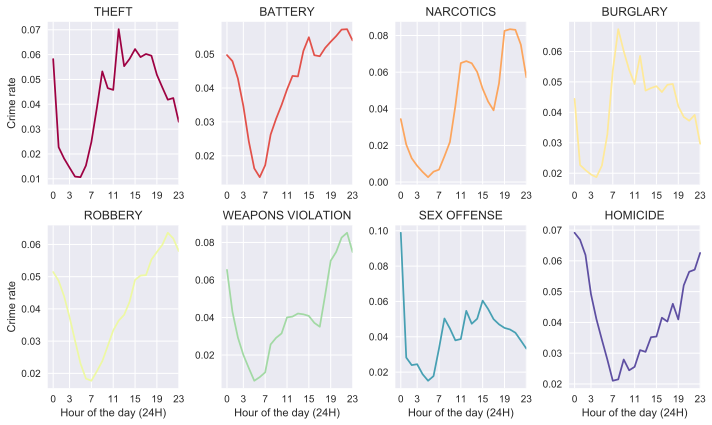

In [18]:
cmap=cm.get_cmap('Spectral')
fig1, axes1= plt.subplots(nrows=2, ncols=4, figsize=(10,6))
N=8
for k, df in enumerate(hourly_dfs):
    c = cmap(float(k)/(N-1))
    df.plot(x=np.arange(24), y='Crime rate', ax=axes1.flat[k], title=crime_types[k], color=c, legend=False)
for i in range(8):
    #axes4.flat[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    axes1.flat[i].xaxis.set_major_locator(plt.FixedLocator(np.array([0, 3, 7, 11, 15, 19, 23])))
    axes1.flat[i].set_xlim((-1,23))
for i in range(4,8):
    axes1.flat[i].set_xlabel('Hour of the day (24H)')
for i in [0, 4]:
    axes1.flat[i].set_ylabel('Crime rate')
plt.tight_layout()
plt.show()

<strong>This is a very interesting plot. Three crimes show similar pattern: "Battery, Robbery and Homicide". They peak at late night and low in the <br>
morning. As it gets darker and darker (from noon to almost midnight), more and more of these three crimes happen. Darkness is still the best cover <br>
for crimes. On the other hand, Theft peaks around 12pm. This is indicative of the time when most people are outside since most thefts happen in <br>
the street. Another interesting pattern is Narcotics which has two distince peaks at around 12pm and 8pm. Without further information, it's going <br>
to be hard to decipher this mystery. Last but not the least, for Burglary crimes, the highest peak is 8am. Any thoughts? Maybe that's because most<br>
people would have left their houses for work around that time and intruders tend to break in assuming no one is home.</strong>

<strong>If we visualize the two peaks of narcotics on the map, where would they be in those communities?</strong>

In [11]:
# Define some functions for later use for the maps
# Define a function to make a simple map object centering on Chicago and set the dimensions
def single_map():
    chicago_coord=(41.8781, -87.6298)
    fig=gmaps.figure(display_toolbar=False, center=chicago_coord, zoom_level=11)
    fig._map.layout.width = '475px'    # Set map width
    fig._map.layout.height = '600px'   # Set map height
    return(fig)

In [12]:
# Define a function to take a list of crimes and assign a color based on an attribute of that community (e.g. income, crimes) 
# and match each color to a community      

def get_colors_from_attr(geo, mini, maxi, attri_dict, color_map):
    colors=[]
    range_=maxi-mini
    for feature in geo['features']:
        area=int(feature['properties']['area_numbe'])
        if area in list(attri_dict.keys()):
            color=color_map((attri_dict[area]-mini)/range_)
            colors.append(to_hex(color, keep_alpha=False))
        else:
            colors.append((0,0,0,0.3))
    return(colors)

In [13]:
# Define a function to draw two maps side by side for comparison
def double_choro_map(communities, centers, colors_1, colors_2, info_box_1, info_box_2, label_1, label_2):
    """
    This function will make two choropleth maps side by side to see comparison
    """
    fig_left=single_map()
    fig_right=single_map()

    legend_template_1='<i style="font-size:20px; color: {color}; vertical-align: top">&#9632;</i>  \
                       <span class="nav-text" style="color:{color}; font-family: roboto; \
                       vertical_align: -5px"></span> {label}'

    legend_template_2='<head><link href="https://fonts.googleapis.com/icon?family=Material+Icons" \
                       rel="stylesheet"> </head>  \
                       <i class="material-icons" style="font-size:20px; color: {color}; \
                       vertical-align: -5px">fiber_manual_record</i>  \
                       <span class="nav-text" style="color:{color}; font-family: roboto;"></span> {label}'

    legend_left_1=legend_template_1.format(color='pink', label=label_1)
    legend_left_2=legend_template_2.format(color='blue', label='Info box marker (click to see)')

    legend_right_1=legend_template_1.format(color='pink', label=label_2)
    legend_right_2=legend_template_2.format(color='blue', label='Info box marker (click to see)')

    layer_left =gmaps.geojson_layer(communities, fill_color=colors_1, fill_opacity=0.8, stroke_weight=1)
    layer_right=gmaps.geojson_layer(communities, fill_color=colors_2, fill_opacity=0.8, stroke_weight=1)

    info_layer_left =gmaps.symbol_layer(centers[['Latitude', 'Longitude']], fill_color='blue', 
                                        stroke_color='blue', info_box_content=info_box_1, scale=3)
    info_layer_right=gmaps.symbol_layer(centers[['Latitude', 'Longitude']], fill_color='blue', 
                                        stroke_color='blue', info_box_content=info_box_2, scale=3)

    fig_left.add_layer(layer_left)
    fig_left.add_layer(info_layer_left)
    fig_right.add_layer(layer_right)
    fig_right.add_layer(info_layer_right)

    left_map =widgets.VBox([fig_left,  widgets.HBox([widgets.HTML(legend_left_1),  widgets.HTML(legend_left_2)], 
                                             layout=widgets.Layout(width='100%', justify_content='flex-start'))])
    right_map=widgets.VBox([fig_right, widgets.HBox([widgets.HTML(legend_right_1), widgets.HTML(legend_right_2)], 
                                             layout=widgets.Layout(width='100%', justify_content='flex-start'))])

    return(widgets.HBox([left_map, right_map], layout=widgets.Layout(width='100%', justify_content='space-between')))

In [14]:
nar_12=all_crimes[(all_crimes.index.hour==12) & (all_crimes['Primary Type']=='NARCOTICS')]
nar_20=all_crimes[(all_crimes.index.hour==20) & (all_crimes['Primary Type']=='NARCOTICS')]

In [15]:
nar_12_by_commu=nar_12['Community Area'].value_counts().reset_index()
nar_20_by_commu=nar_20['Community Area'].value_counts().reset_index()

In [16]:
nar_12_by_commu.columns=['Community', 'Narcotics']
nar_20_by_commu.columns=['Community', 'Narcotics']

In [17]:
nar_12_by_commu=nar_12_by_commu[nar_12_by_commu['Community']!=0]
nar_20_by_commu=nar_20_by_commu[nar_20_by_commu['Community']!=0]

In [18]:
nar_12_by_commu=nar_12_by_commu.sort_values('Community')
nar_20_by_commu=nar_20_by_commu.sort_values('Community')

In [19]:
nar_12_min=nar_12_by_commu['Narcotics'].min()
nar_12_max=nar_12_by_commu['Narcotics'].max()
nar_20_min=nar_20_by_commu['Narcotics'].min()
nar_20_max=nar_20_by_commu['Narcotics'].max()
nar_12_colors=get_colors_from_attr(community_areas, nar_12_min, nar_12_max, 
                                      dict(zip(nar_12_by_commu['Community'], 
                                               nar_12_by_commu['Narcotics'])), color_map)
nar_20_colors=get_colors_from_attr(community_areas, nar_20_min, nar_20_max, 
                                          dict(zip(nar_20_by_commu['Community'], 
                                                   nar_20_by_commu['Narcotics'])), color_map)

In [20]:
# Set up info box contents
nar_12_info=[str(i)+'-'+j+'<br>'+'Narcotics: ' +str(k) for i, j, k \
                in zip(community_centers['community'], community_centers['Community Name'], 
                nar_12_by_commu['Narcotics'])]
nar_20_info=[str(i)+'-'+j+'<br>'+'Narcotics: ' +str(k) for i, j, k \
                    in zip(community_centers['community'], community_centers['Community Name'], 
                    nar_20_by_commu['Narcotics'])]

In [ ]:
# Show the map. Please download and execute locally.
double_choro_map(community_areas, community_centers, nar_12_colors, nar_20_colors, nar_12_info, nar_20_info, 
                 'Narcotics peak at 12pm', 'Narcotics peak at 8pm')

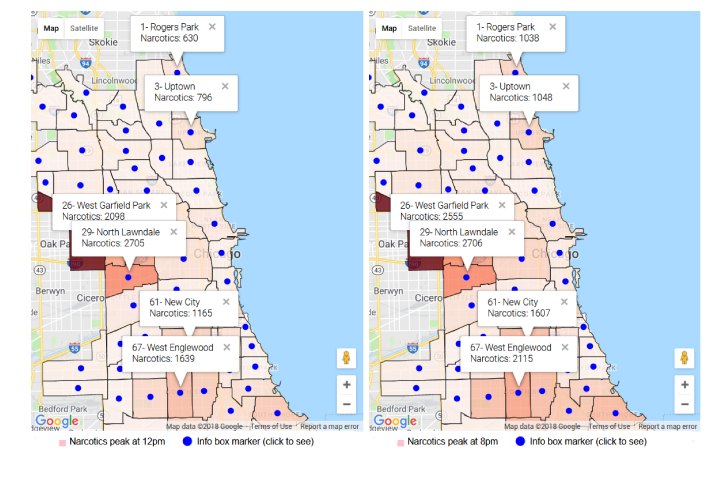

In [4]:
# Load a local screenshot of the above interactive map to avoid bloating the notebook
map1=plt.imread('narcotics 12pm and 8pm.png')
plt.figure(figsize=(12, 12), dpi=300)
plt.axis('off')
plt.grid(False)
plt.imshow(map1)

In [4]:
all_crimes['Hour']=all_crimes.index.hour

In [6]:
# Let's do a statistical test to show that for New City (community 61), there is more narcotics at 8pm than 12pm.
# But for North Lawndale (community 29), there no difference between 8pm and 12pm.
narc_8pm_newcity=all_crimes[(all_crimes['Hour']==20) & (all_crimes['Primary Type']=='NARCOTICS') & \
                           (all_crimes['Community Area']==61)]['Primary Type'].resample('A').count()
narc_12pm_newcity=all_crimes[(all_crimes['Hour']==12) & (all_crimes['Primary Type']=='NARCOTICS') & \
                           (all_crimes['Community Area']==61)]['Primary Type'].resample('A').count()
narc_8pm_northlawn=all_crimes[(all_crimes['Hour']==20) & (all_crimes['Primary Type']=='NARCOTICS') & \
                           (all_crimes['Community Area']==29)]['Primary Type'].resample('A').count()
narc_12pm_northlawn=all_crimes[(all_crimes['Hour']==12) & (all_crimes['Primary Type']=='NARCOTICS') & \
                           (all_crimes['Community Area']==29)]['Primary Type'].resample('A').count()

In [7]:
df1=pd.concat([narc_8pm_newcity, narc_12pm_newcity, narc_8pm_northlawn, narc_12pm_northlawn], axis=1)

In [15]:
df1.columns=['New City 8pm', 'New City 12pm', 'North Lawndale 8pm', 'North Lawndale 12pm']
df1

,New City 8pm,New City 12pm,North Lawndale 8pm,North Lawndale 12pm
Date,,,,
2002-12-31,85.0,64.0,112,89.0
2003-12-31,184.0,101.0,235,202.0
2004-12-31,125.0,126.0,285,293.0
2005-12-31,126.0,90.0,274,288.0
2006-12-31,138.0,145.0,221,289.0
2007-12-31,136.0,98.0,197,174.0
2008-12-31,149.0,66.0,151,163.0
2009-12-31,112.0,66.0,174,146.0
2010-12-31,116.0,78.0,150,169.0


In [10]:
# Discard first row
df1=df1.iloc[1:, :]

In [11]:
df1

,New city 8pm,New city 12 pm,North Lawndale 8pm,North Lawndale 12pm
Date,,,,
2002-12-31,85.0,64.0,112,89.0
2003-12-31,184.0,101.0,235,202.0
2004-12-31,125.0,126.0,285,293.0
2005-12-31,126.0,90.0,274,288.0
2006-12-31,138.0,145.0,221,289.0
2007-12-31,136.0,98.0,197,174.0
2008-12-31,149.0,66.0,151,163.0
2009-12-31,112.0,66.0,174,146.0
2010-12-31,116.0,78.0,150,169.0


In [16]:
# Now let's compare the March and December for Austin and East Garfield Park
newcity_test=sm_ttest(df1['New City 8pm'].values, df1['New City 12pm'].values, alternative='larger')

In [17]:
# Now let's compare the March and December for Austin and East Garfield Park
northlawn_test=sm_ttest(df1['North Lawndale 8pm'].values, df1['North Lawndale 12pm'].values, alternative='two-sided')

In [18]:
df2=pd.DataFrame({'New City': newcity_test[1], 'North Lawndale': northlawn_test[1]}, index=['p value'])

In [19]:
df2.index.name='Compare 8pm to 12pm'

In [20]:
df2

,New City,North Lawndale
Compare 8pm to 12pm,,
p value,0.03505,1.0


<strong>They pretty much looks the same but in West Englewood there are a lot more cases at 8pm. We can make a plot to compare 12pm and 8pm for all communities as bar graphs. </strong>

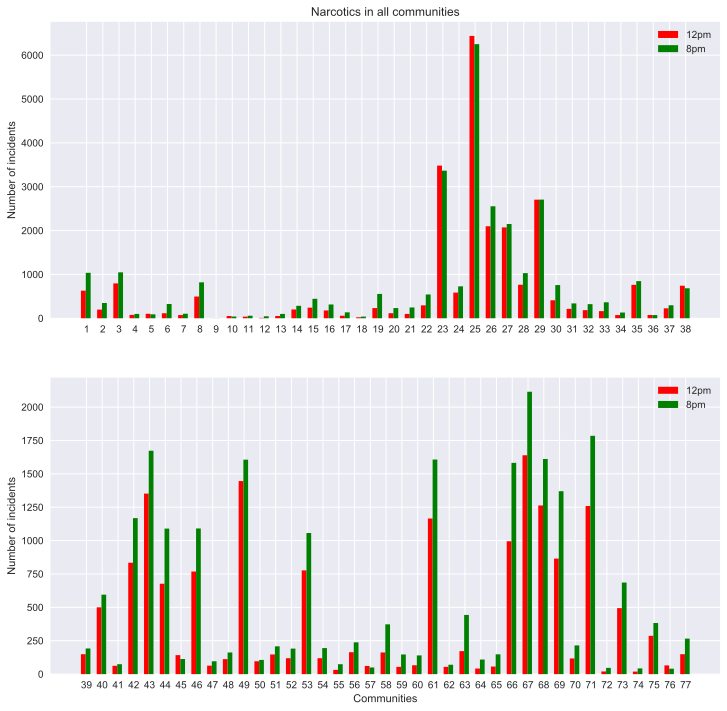

In [34]:
fig2, axes2= plt.subplots(nrows=2, ncols=1, figsize=(12,12))
w=0.3
x1=np.arange(len(nar_12_by_commu))[0:38]
x2=np.arange(len(nar_12_by_commu))[38:]
axes2.flat[0].bar(x1, nar_12_by_commu['Narcotics'].values[0:38], width=w, color='r', align='center', label='12pm')
axes2.flat[0].bar(x1+w, nar_20_by_commu['Narcotics'].values[0:38], width=w, color='g', align='center', label='8pm')
axes2.flat[1].bar(x2, nar_12_by_commu['Narcotics'].values[38:], width=w, color='r', align='center', label='12pm')
axes2.flat[1].bar(x2+w, nar_20_by_commu['Narcotics'].values[38:], width=w, color='g', align='center', label='8pm')
#ax.bar(x+w, nar_20_by_commu['Narcotics'].values, width=w, color='b', align='center')
axes2.flat[0].set_xticks(x1+0.2)
axes2.flat[0].set_xticklabels((y for y in nar_12_by_commu['Community'].values[0:38]))
axes2.flat[0].legend()
axes2.flat[0].set_title('Narcotics in all communities')
axes2.flat[0].set_ylabel('Number of incidents')
axes2.flat[1].set_xticks(x2+0.2)
axes2.flat[1].set_xticklabels((y for y in nar_12_by_commu['Community'].values[38:]))
axes2.flat[1].legend()
axes2.flat[1].set_xlabel('Communities')
axes2.flat[1].set_ylabel('Number of incidents')
plt.show()

<strong>From the above bar graph, we can see that for communities 1-38 there is not much difference, however, for communities 39-77, in 42, 43, 44 and 46 there are apparently more crimes at 8pm compared to 12pm. This is also true for communities 61, 66, 67, 68, 69, and 71. These seem to be two clusters.</strong>

We can also sort crimes by communities to see which communities have the most crimes.

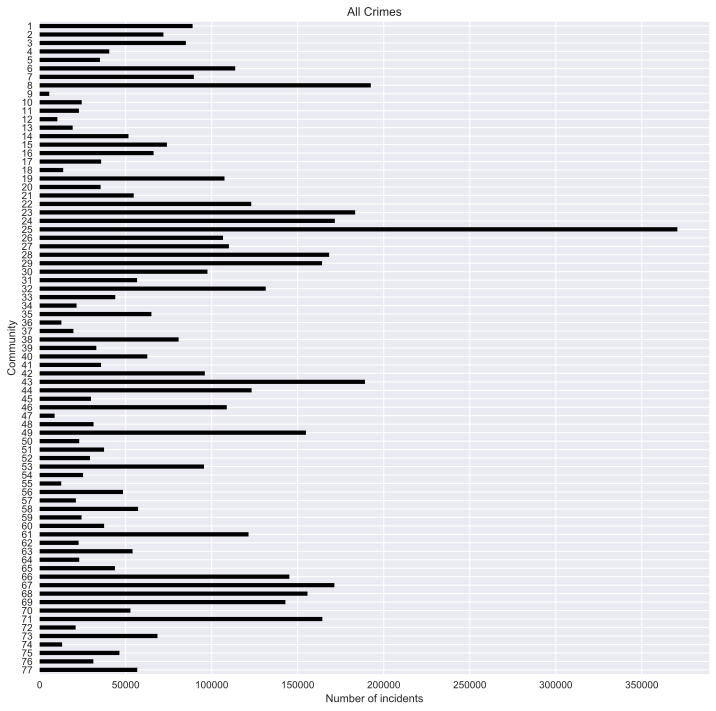

In [14]:
plt.figure(figsize=(12,12))
crimes_ml['Community Area'].value_counts().sort_index(ascending=False).plot(kind='barh', color='black')
plt.xlabel('Number of incidents')
plt.ylabel('Community')
plt.title('All Crimes')
plt.show()

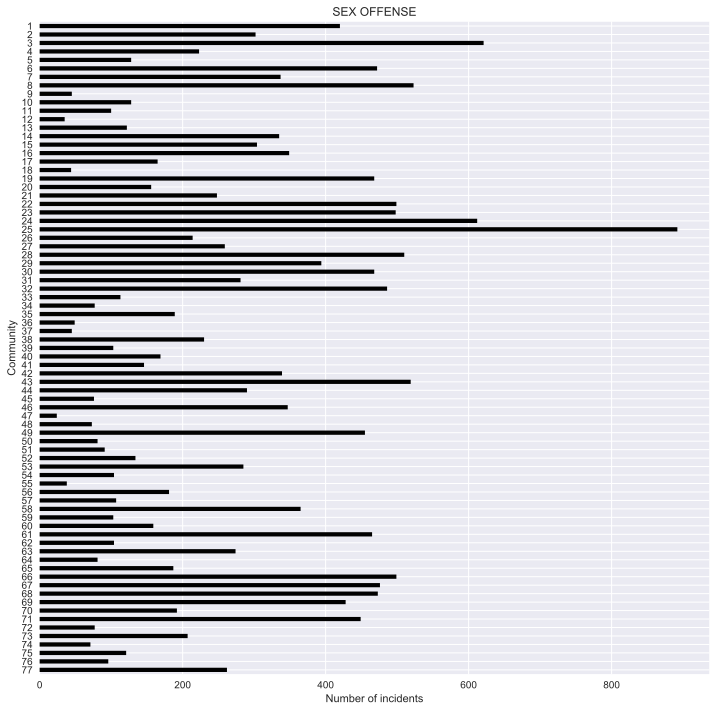

In [13]:
select=crime_types[21]
plt.figure(figsize=(12,12))
crimes_ml[crimes_ml['Primary Type']==select]['Community Area'].value_counts().sort_index(ascending=False).plot(kind='barh',
                                                                                                               color='black')
plt.xlabel('Number of incidents')
plt.ylabel('Community')
plt.title(select)
plt.show()

<h3>Last question: If we plot all crimes from 2001 to 2016 as choropleth map, which communities are the most dangerous? Maybe those are the communities where safety issue should be treated seriously.</h3>

In [36]:
# First group crimes by communities
by_commu=all_crimes.groupby('Community Area')['ID'].count()

In [41]:
by_commu=by_commu.reset_index()
by_commu.columns=['Community', 'Crimes']

In [42]:
by_commu=by_commu[by_commu['Community']!=0]

In [46]:
commu_min=by_commu['Crimes'].min()
commu_max=by_commu['Crimes'].max()
commu_colors=get_colors_from_attr(community_areas, commu_min, commu_max, 
                                      dict(zip(by_commu['Community'], 
                                               by_commu['Crimes'])), color_map)

In [51]:
# Set up info box contents
commu_info_box=[str(i)+'-'+j+'<br>'+'Total crimes (01-16): ' +str(k) for i, j, k \
                in zip(community_centers['community'], community_centers['Community Name'], 
                       by_commu['Crimes'])]

In [ ]:
# Please download and execute locally.
commu_map=single_map()

legend_template_1='<i style="font-size:20px; color: {color}; vertical-align: top">&#9632;</i>  \
                       <span class="nav-text" style="color:{color}; font-family: roboto; \
                       vertical_align: -5px"></span> {label}'

legend_template_2='<head><link href="https://fonts.googleapis.com/icon?family=Material+Icons" \
                   rel="stylesheet"> </head>  \
                   <i class="material-icons" style="font-size:20px; color: {color}; \
                   vertical-align: -5px">fiber_manual_record</i>  \
                   <span class="nav-text" style="color:{color}; font-family: roboto;"></span> {label}'

commu_legend_1=legend_template_1.format(color='pink', label='All crimes between 2001 and 2016')
commu_info=legend_template_2.format(color='blue', label='info box (click to see)')

commu_layer=gmaps.geojson_layer(community_areas, fill_color=commu_colors, fill_opacity=0.8, stroke_weight=1)
commu_info_layer=gmaps.symbol_layer(community_centers[['Latitude', 'Longitude']], fill_color='blue', 
                                    stroke_color='blue', info_box_content=commu_info_box, scale=3)

commu_map.add_layer(commu_layer)
commu_map.add_layer(commu_info_layer)
widgets.VBox([commu_map, widgets.HBox([widgets.HTML(commu_legend_1),  widgets.HTML(commu_info)], 
                                             layout=widgets.Layout(width='100%', justify_content='flex-start'))])

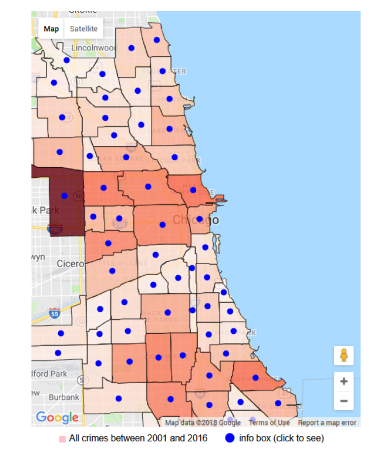

In [7]:
# Load a local screenshot of the above interactive map
map2=plt.imread('all crimes.png')
plt.figure(figsize=(8, 8), dpi=300)
plt.axis('off')
plt.grid(False)
plt.imshow(map2)

<strong>From the above map we can see that there are three major clusters of crimes: 1. The downtown area  2. The West side   3. The South Since this map shows all crimes and of course different crimes will happen in different areas but this still gives some insights into where crimes occur the most in the city. What's interesting is that, the west and south are known to be "bad areas" but the north is usually a good area. Why is there a cluster just right north of Lincoln Park? Maybe certain crimes tend to happen there even though the social class is better? These are further questions that can be explored. </strong>

<h3> Conclusion: <br>
1. Overall crimes are going down in Chicago (except Weapons Violation). However, the huge spike of homicide in 2016 is disturbing and worth investigation.<br><br>
2. Crimes tend to happen in warm month where temperatures are around 70 degrees with the exception of Narcotics violations. This is an interesting find and can be explored if more information is known.<br><br>
3. Different crimes spread out differently during the week. As shown by the corresponding figure,  battery seems to be high on the weekend on the other hand, Burglary seems to be lower on the weekend. Theft is the highest on Friday while homicide is the highest on Sunday. <br><br>
4. Battery, Robbery and Homicide peak at late night and low in the morning. On the other hand, Theft peaks around 12pm. Another interesting pattern is Narcotics which has two distince peaks at around 12pm and 8pm. For Burglary crimes, the highest peak is 8am. These could be further explored if combined with more useful information.<br><br>
5. Finally, based on the map visualization, we have identified some hot areas for crimes to happen. The truth behind these clusterings could be revealed by using statistics in those areas such as income level, poverty, education level or demographics. <br><br>